# Marine Diatoms: Modeling using K-Means Clustering with Data Analysis
Paper Name: Enhanced biofilm formation aids adaptation to extreme warming and environmental instability in the diatom Thalassiosira pseudonana and its associated bacteria

In [50]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
import scipy.stats as stats
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

The data I used was from a paper on biofilm formation on [diatoms](https://en.wikipedia.org/wiki/Thalassiosira_pseudonana).

Marine diatoms are a proxy for the effects of climate change on the oceans as they are [sensitive to changes](https://www.nature.com/articles/s41558-019-0557-y). They are also a foundation of the oceans food web. Therefore, understanding how diatoms adapt to increased ocean temperatures and acidification is imperitive to predict climate change's future effects.

Diatoms also have a resident microbiota of bacteria, which may confer protections and vital nutrients that help with adaptations under duress. The paper we will be studying has carried out a 400-generation selection for bacterial biofilm formation on the diatoms in several conditions. Using their data, we will rediscover several properties about how diatoms and biofilms react to stressors.

Paper: https://aslopubs.onlinelibrary.wiley.com/doi/10.1002/lno.11050

Datasets: https://zenodo.org/record/1438977

In [51]:
# Here we can use Pandas to import our data
df1 = pd.read_csv('/Users/sveerisetti/Desktop/Boston_University/Semester2/BF_550_Python/Labs/KMeans/20183009_biofilm_characterise.csv')
df1.columns = ['characteristic', 'selection_temp', 'bio_replicate', 'nutrient', 'sampletype', 'traitvalue'] 
df1

,characteristic,selection_temp,bio_replicate,nutrient,sampletype,traitvalue
0,size,22,b1,full,p,11.43
1,size,22,b2,full,p,10.46
2,size,22,b3,full,p,11.23
3,size,22,b4,full,p,11.33
4,size,22,b5,full,p,10.47
...,...,...,...,...,...,...
427,bacload,FS,b2,deplete,pbf,0.01
428,bacload,FS,b3,deplete,pbf,0.35
429,bacload,FS,b4,deplete,pbf,0.46
430,bacload,FS,b5,deplete,pbf,0.30


In [52]:
id_cols = ['sampletype', 'nutrient', 'selection_temp', 'bio_replicate']
df2 = df1.copy() # so that we don't mess with the original df
# df2['id'] = df2[id_cols].agg('_'.join, axis=1) # we could also join the identifying columns so we have one index
df2 = df2.pivot(index=id_cols, columns='characteristic', values='traitvalue')
df2.rename(columns={"size":"Size"}, inplace=True) # why might we want to rename 'size' to 'Size'? What does inplace=True mean?
df2 = df2.reset_index()
df2

characteristic,sampletype,nutrient,selection_temp,bio_replicate,bacload,chlorophyll,Size
0,bf,deplete,22,b1,12.00,0.778,9.20
1,bf,deplete,22,b2,7.30,1.187,10.40
2,bf,deplete,22,b3,15.00,0.599,11.03
3,bf,deplete,22,b4,9.00,1.985,11.09
4,bf,deplete,22,b5,10.00,0.950,10.51
...,...,...,...,...,...,...,...
139,pbf,full,FS,b2,1.09,0.792,7.19
140,pbf,full,FS,b3,0.06,0.306,10.42
141,pbf,full,FS,b4,0.07,0.603,10.90
142,pbf,full,FS,b5,0.12,0.501,10.06


# K Means Clustering

Here we can use [sklearn's KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the data by 'chlorophyll' and 'Size'.

1. Here we want to subset the dataframe to include only the 'chlorophyll' and 'Size' variables.
2. Then we want to use the Kmeans function and .fit() method on the subset for k=2.
3. Then we want to make the same 'Size' vs 'chlorophyll' plot, but use the cluster label for each point as the hue.
4. Next, overlay the cluster centers as another scatter plot.
5. Finally, we want to compare the clustering result to the nutrient plot.

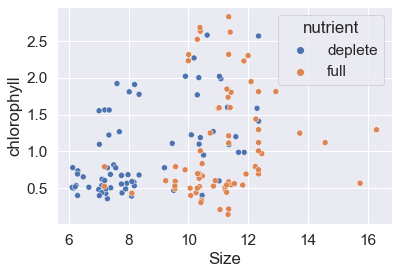

In [53]:
sns.scatterplot(data = df2, x = 'Size', y = 'chlorophyll', hue = 'nutrient')
plt.show()

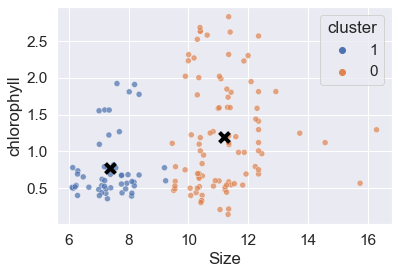

In [54]:
X = df2.copy()[['chlorophyll','Size']]
k = 2

#Here we want to build and fit our model
Kmean = KMeans(n_clusters=k).fit(X)

#How are we going to differentiate between different clusters? We will label them based on the cluster group
X['cluster'] = Kmean.labels_
X['cluster'] = X['cluster'].astype('str')

#We can use the cluster_centers_ function in order to determine the Kmean cluster centers
centers = Kmean.cluster_centers_

#We can use seaborn to create a scatter plot with the size as the x-axis and the chlorophyll as the y-axis. 
sns.scatterplot(data=X, x= 'Size', y= 'chlorophyll',hue='cluster', alpha=0.7)
plt.scatter(x=centers[:,1], y=centers[:,0],
            color= 'black', marker= 'x', s=100, linewidth=4)
plt.show()

# Elbow Method
Here we can use the '[Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)' to determine which number of clusters is the best.

1. Using the code from KMeans, we can then plot number of clusters $k \in \{1, 2, 3, 4, 5, 6, 7\} $. 
2. Then, we need to add the $k$ value to the title of each plot.
2. For each $k$ we can save the sum of squared distances (SSD). This is stored in the Kmean class instance, find the correct attribute.
3. Then, we can plot $k$ vs SSD.

In [55]:
#We want to create empty lists so that we can append distortion and inertia values to them
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

#We want to cap our clusters at 7
#K = range(1, 7)
X = df2.copy()[['chlorophyll','Size']]
  
for k in range(1, 7):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    #The cdist() function will compute the distance between each pair of the two collections of inputs.
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    #Here we want to calculate the intertia values for our model 
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [56]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.9358115493963746
2 : 1.0180867877804698
3 : 0.8571677044581736
4 : 0.758453319413174
5 : 0.6399568121154492
6 : 0.5849564966687925


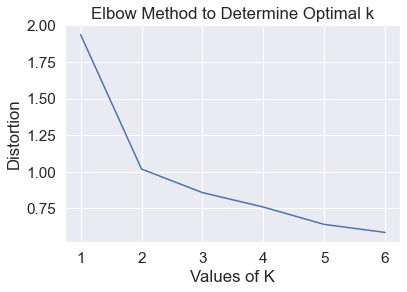

In [57]:
#Here we want to plot our elbow plot
plt.plot(K, distortions)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

#We should choose 2 clusters. Where is the elbow in the image below? 

# Normalization


1. Here we want Normalize 'chlorophyll' and 'Size' by dividing by the mean value from each of those features and re-cluster using the normalized data. 
2. Then we want to plot the normalized data and clusters for $k \in \{1, 2, 3, 4, 5, 6, 7\} $ 

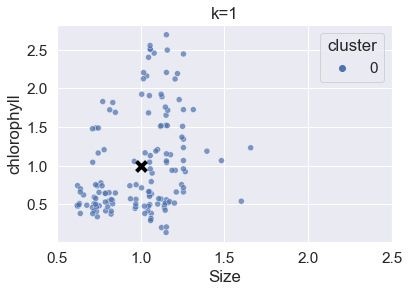

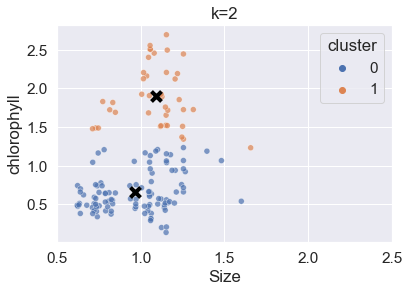

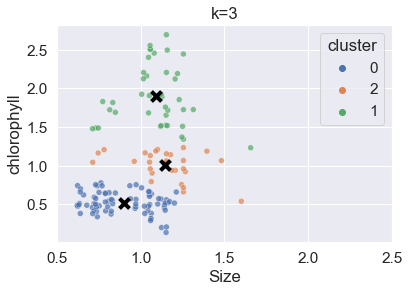

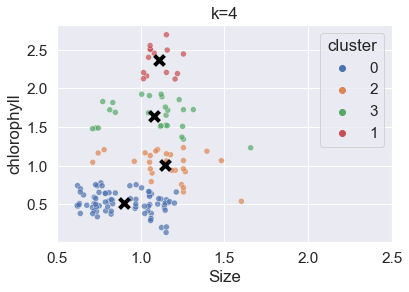

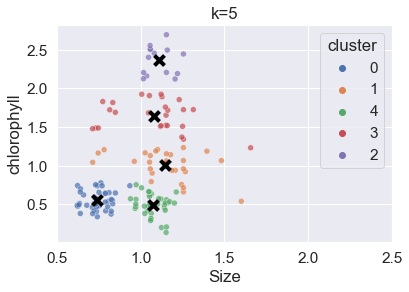

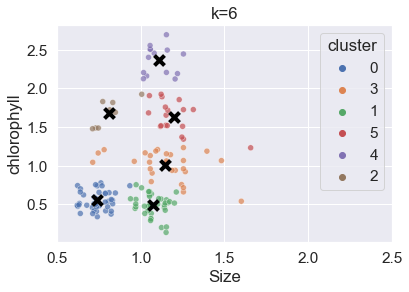

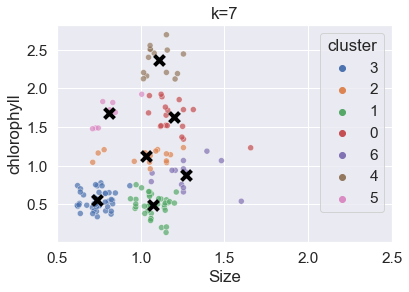

In [58]:
X = df2.copy()[['chlorophyll','Size']]
X.chlorophyll = X.chlorophyll / X.chlorophyll.mean()
X.Size = X.Size / X.Size.mean()
ssd2 = [] 
Ks = range(1,8)
for k in Ks:
    Kmean = KMeans(n_clusters=k).fit(X)
    X['cluster'] = Kmean.labels_
    X['cluster'] = X['cluster'].astype('str')
    centers = Kmean.cluster_centers_
    
    sns.scatterplot(data=X, x='Size', y='chlorophyll', hue='cluster', alpha=0.7)
    plt.scatter(x=centers[:,1], y=centers[:,0],
                color='black', marker='x', s=100, linewidth=4)
    plt.title(f'k={k}')
    plt.xlim(0.5, 2.5)

    plt.show()
    
    ssd2.append(Kmean.inertia_)

# Data Analysis

1. Here we want to reproduce the plot with the best normalization algorithm and the best k from that algorithm.


In [59]:
def normalize(v):
    '''
    v = the data for a single feature in array format
    returns the array normalized
    '''
    return (v - min(v)) / (max(v) - min(v))

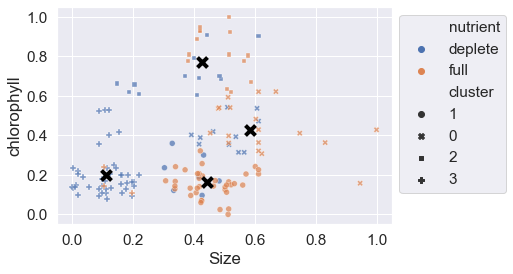

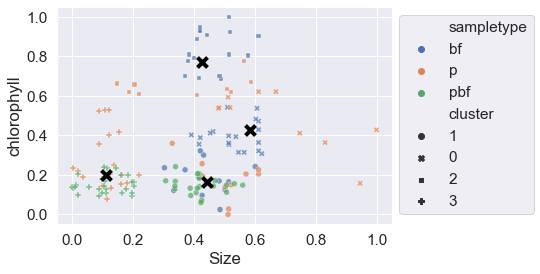

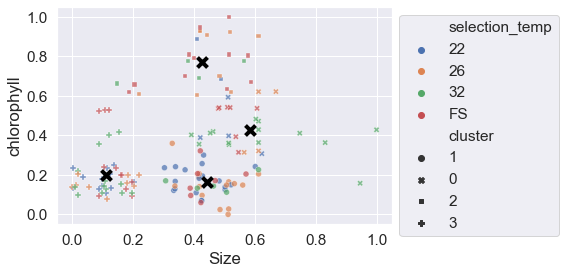

In [60]:
df3 = df2.copy()
df3.chlorophyll = normalize(df3.chlorophyll)
df3.Size = normalize(df3.Size)
X = df3.copy()[['chlorophyll','Size']]

k=4
Kmean = KMeans(n_clusters=k).fit(X)
df3['cluster'] = Kmean.labels_
df3['cluster'] = df3['cluster'].astype('str')

centers = Kmean.cluster_centers_

labels = ['nutrient', 'sampletype', 'selection_temp']

for label in labels:
    g = sns.scatterplot(data=df3, x='Size', y='chlorophyll', hue=label, style='cluster', alpha=0.7)
    plt.scatter(x=centers[:,1], y=centers[:,0],
                color='black', marker='x', s=100, linewidth=4)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.show()